<a href="https://colab.research.google.com/github/vysf/machine-learning-practice/blob/master/Submission_Membuat_Model_Machine_Learning_dengan_Data_Time_Series_(Proyek_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/JPM_2006-01-01_to_2018-01-01.csv')
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.83,40.36,39.30,40.19,12839400,JPM
1,2006-01-04,39.78,40.14,39.42,39.62,13491800,JPM
2,2006-01-05,39.61,39.81,39.50,39.74,8109400,JPM
3,2006-01-06,39.92,40.24,39.55,40.02,7966900,JPM
4,2006-01-09,39.88,40.72,39.88,40.67,16575200,JPM


In [ ]:
df.isnull().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [ ]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Name              object
dtype: object

In [ ]:
print(f"Total record = {df.shape[0]} data")

Total record = 3020 data


In [ ]:
df = df.fillna(method="bfill")
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

Text(0.5, 1.0, 'Stock price : JPM')

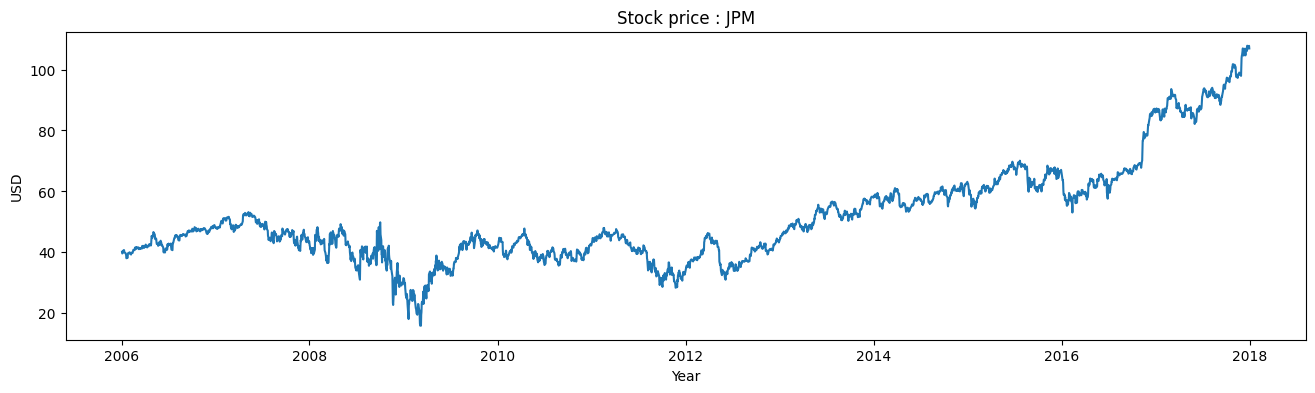

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(df["Date"], df["Close"])
plt.xlabel("Year")
plt.ylabel("USD")
plt.title(f"Stock price : {df['Name'][0]}")

In [ ]:
output_var = pd.DataFrame(df["Close"])
features = ["Open", "High", "Low", "Volume"]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.263492,0.253044,0.263991,0.052576
1,0.262954,0.250631,0.265293,0.055599
2,0.261122,0.247011,0.266161,0.030658
3,0.264462,0.251728,0.266703,0.029997
4,0.264031,0.256992,0.270282,0.069887


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_transform, output_var, test_size=0.2, shuffle=False)

def percentage(rasio, total):
  return rasio/total * 100
print(f"Rasio data train = {percentage(len(y_train), len(y_train) + len(y_test))} %")
print(f"Rasio data test = {percentage(len(y_test), len(y_train) + len(y_test))} %")

Rasio data train = 80.0 %
Rasio data test = 20.0 %


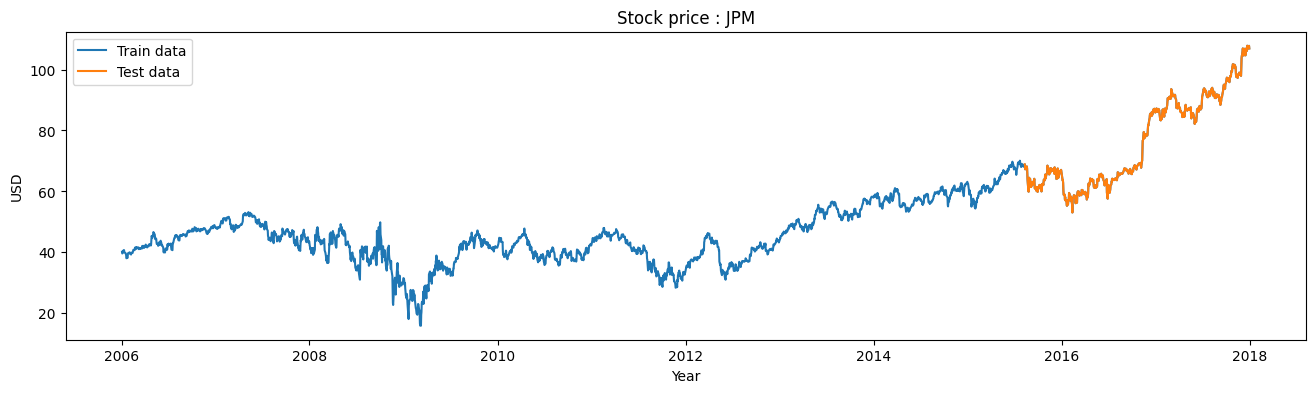

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(df["Date"], df["Close"], label="Train data")
plt.plot(df["Date"].iloc[y_test.index], df["Close"].iloc[y_test.index], label="Test data")
plt.xlabel("Year")
plt.ylabel("USD")
plt.title(f"Stock price : {df['Name'][0]}")
plt.legend()

In [ ]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
threshold_mae = (df['Close'].max() - df['Close'].min()) * 10/100
print(f"threshold (MAE) = {threshold_mae}")

threshold (MAE) = 9.193


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False),
  tf.keras.layers.Dense(1),
])


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("mae") < threshold_mae):
      self.model.stop_training = True

callback = myCallback()

history=model.fit(
    X_train, y_train,
    epochs=100, batch_size=8,
    verbose=1, shuffle=False,
    callbacks=[callback]
)

Epoch 1/100
302/302 [==============================] - 6s 6ms/step - loss: 44.5724 - mae: 45.0724
Epoch 2/100
302/302 [==============================] - 2s 5ms/step - loss: 44.2480 - mae: 44.7480
Epoch 3/100
302/302 [==============================] - 2s 6ms/step - loss: 43.9272 - mae: 44.4272
Epoch 4/100
302/302 [==============================] - 2s 7ms/step - loss: 43.6079 - mae: 44.1079
Epoch 5/100
302/302 [==============================] - 2s 7ms/step - loss: 43.2887 - mae: 43.7887
Epoch 6/100
302/302 [==============================] - 2s 8ms/step - loss: 42.9680 - mae: 43.4680
Epoch 7/100
302/302 [==============================] - 2s 6ms/step - loss: 42.6445 - mae: 43.1445
Epoch 8/100
302/302 [==============================] - 2s 6ms/step - loss: 42.3174 - mae: 42.8174
Epoch 9/100
302/302 [==============================] - 2s 5ms/step - loss: 41.9856 - mae: 42.4856
Epoch 10/100
302/302 [==============================] - 1s 3ms/step - loss: 41.6478 - mae: 42.1478
Epoch 11/100
302/30

In [ ]:
y_pred = model.predict(X_test)

19/19 [==============================] - 0s 3ms/step


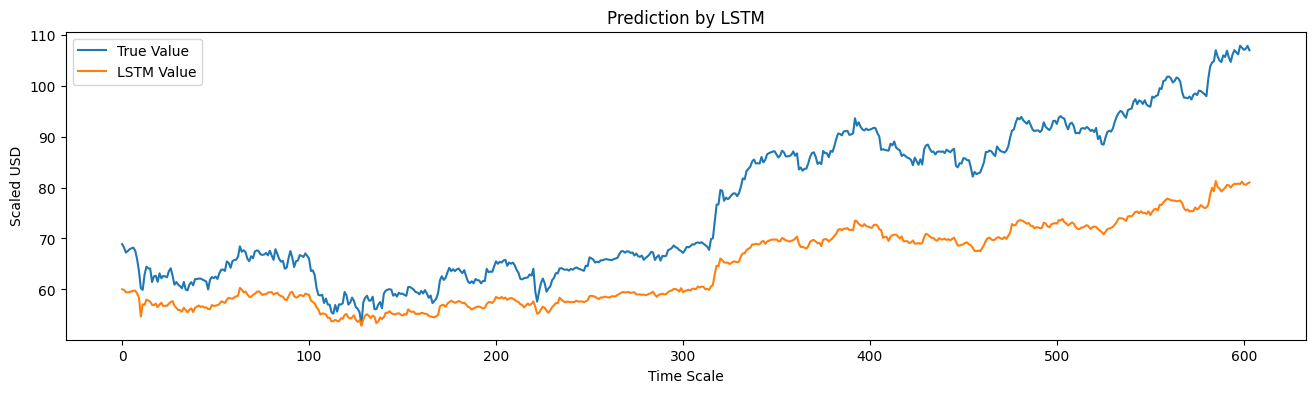

In [ ]:
#Predicted vs True Adj Close Value – LSTM
plt.figure(figsize=(16, 4))
plt.plot(y_test.values, label="True Value")
plt.plot(y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Scaled USD")
plt.legend()
plt.show()